In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 224

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [3]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    return model

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    

In [4]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

In [5]:
use_gpu = torch.cuda.is_available()

In [6]:
labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

In [8]:
train_set = SuperheroesDataset(x_train, y_train, transform_data)
train_load = DataLoader(train_set,batch_size=64)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_data)
valid_load = DataLoader(valid_set,batch_size=64)
test_set = SuperheroesDataset(x_test, y_test, transform_data)
test_load = DataLoader(test_set,batch_size=1)

In [9]:
image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 2.3614 Acc: 0.1417
val Loss: 2.3151 Acc: 0.1638

Epoch 1/24
----------
train Loss: 2.3190 Acc: 0.1705
val Loss: 2.2972 Acc: 0.1748

Epoch 2/24
----------
train Loss: 2.3058 Acc: 0.1884
val Loss: 2.2835 Acc: 0.1794

Epoch 3/24
----------
train Loss: 2.2939 Acc: 0.2009
val Loss: 2.2712 Acc: 0.1822

Epoch 4/24
----------
train Loss: 2.2833 Acc: 0.2050
val Loss: 2.2602 Acc: 0.1978

Epoch 5/24
----------
train Loss: 2.2736 Acc: 0.2119
val Loss: 2.2500 Acc: 0.2006

Epoch 6/24
----------
train Loss: 2.2646 Acc: 0.2181
val Loss: 2.2407 Acc: 0.2107

Epoch 7/24
----------
train Loss: 2.2563 Acc: 0.2234
val Loss: 2.2320 Acc: 0.2180

Epoch 8/24
----------
train Loss: 2.2485 Acc: 0.2289
val Loss: 2.2240 Acc: 0.2199

Epoch 9/24
----------
train Loss: 2.2412 Acc: 0.2335
val Loss: 2.2165 Acc: 0.2217

Epoch 10/24
----------
train Loss: 2.2344 Acc: 0.2407
val Loss: 2.2095 Acc: 0.2272

Epoch 11/24
----------
train Loss: 2.2279 Acc: 0.2441
val Loss: 2.2029 Acc: 0.2309

Ep

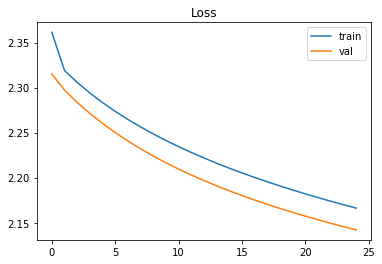

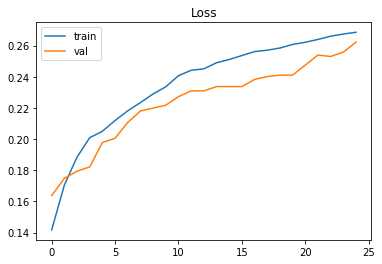

In [105]:
torch.random.manual_seed(12345)
#model_conv.apply(reset)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
model_conv_sgd = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3429 Acc: 0.1618
val Loss: 2.2856 Acc: 0.1785

Epoch 1/24
----------
train Loss: 2.2560 Acc: 0.2080
val Loss: 2.2280 Acc: 0.1978

Epoch 2/24
----------
train Loss: 2.2093 Acc: 0.2315
val Loss: 2.1888 Acc: 0.2098

Epoch 3/24
----------
train Loss: 2.1757 Acc: 0.2494
val Loss: 2.1593 Acc: 0.2291

Epoch 4/24
----------
train Loss: 2.1487 Acc: 0.2648
val Loss: 2.1355 Acc: 0.2392

Epoch 5/24
----------
train Loss: 2.1259 Acc: 0.2782
val Loss: 2.1153 Acc: 0.2475

Epoch 6/24
----------
train Loss: 2.1059 Acc: 0.2883
val Loss: 2.0978 Acc: 0.2530

Epoch 7/24
----------
train Loss: 2.0882 Acc: 0.2950
val Loss: 2.0825 Acc: 0.2649

Epoch 8/24
----------
train Loss: 2.0721 Acc: 0.3030
val Loss: 2.0688 Acc: 0.2732

Epoch 9/24
----------
train Loss: 2.0575 Acc: 0.3102
val Loss: 2.0566 Acc: 0.2833

Epoch 10/24
----------
train Loss: 2.0440 Acc: 0.3152
val Loss: 2.0457 Acc: 0.2879

Epoch 11/24
----------
train Loss: 2.0315 Acc: 0.3217
val Loss: 2.0357 Acc: 0.2935

Ep

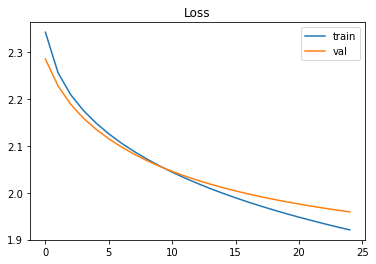

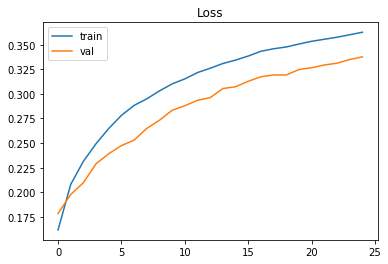

In [107]:
torch.random.manual_seed(12345)
model_conv.apply(reset)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
model_conv_sgd_001 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5976 Acc: 0.1845
val Loss: 2.6646 Acc: 0.1463

Epoch 1/24
----------
train Loss: 2.6987 Acc: 0.2154
val Loss: 3.8484 Acc: 0.1868

Epoch 2/24
----------
train Loss: 2.7693 Acc: 0.2430
val Loss: 3.3269 Acc: 0.2355

Epoch 3/24
----------
train Loss: 2.4702 Acc: 0.2692
val Loss: 2.7360 Acc: 0.2300

Epoch 4/24
----------
train Loss: 2.3590 Acc: 0.2846
val Loss: 2.7303 Acc: 0.2401

Epoch 5/24
----------
train Loss: 2.3135 Acc: 0.2987
val Loss: 2.6746 Acc: 0.2337

Epoch 6/24
----------
train Loss: 2.2546 Acc: 0.3083
val Loss: 2.4613 Acc: 0.2456

Epoch 7/24
----------
train Loss: 2.2039 Acc: 0.3157
val Loss: 2.6007 Acc: 0.2300

Epoch 8/24
----------
train Loss: 2.2303 Acc: 0.3231
val Loss: 2.7153 Acc: 0.2392

Epoch 9/24
----------
train Loss: 2.2348 Acc: 0.3194
val Loss: 2.6370 Acc: 0.2282

Epoch 10/24
----------
train Loss: 2.2934 Acc: 0.3237
val Loss: 2.6849 Acc: 0.2631

Epoch 11/24
----------
train Loss: 2.2433 Acc: 0.3334
val Loss: 2.4520 Acc: 0.2999

Ep

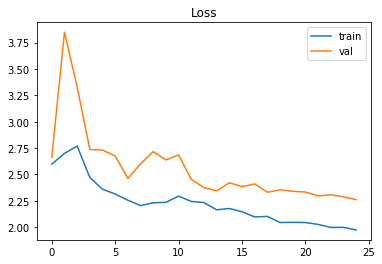

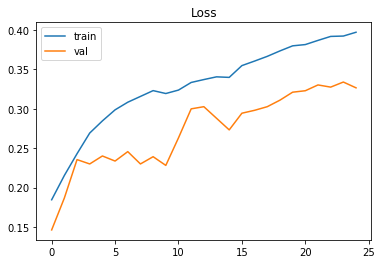

In [109]:
torch.random.manual_seed(12345)
model_conv.apply(reset)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.1, momentum=0.9)
model_conv_sgd_01 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
torch.random.manual_seed(12345)
model_conv.apply(reset)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
model_conv_sgd_01 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [113]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
train Loss: 2.4314 Acc: 0.1362
val Loss: 2.3425 Acc: 0.1803

Epoch 1/4
----------
train Loss: 2.2991 Acc: 0.2046
val Loss: 2.2423 Acc: 0.2511

Epoch 2/4
----------
train Loss: 2.2242 Acc: 0.2731
val Loss: 2.1697 Acc: 0.2723

Epoch 3/4
----------
train Loss: 2.1574 Acc: 0.2855
val Loss: 2.1001 Acc: 0.2953

Epoch 4/4
----------
train Loss: 2.0929 Acc: 0.3007
val Loss: 2.0388 Acc: 0.3008

Training complete in 1m 59s
Best val Acc: 0.300828, epoch 4


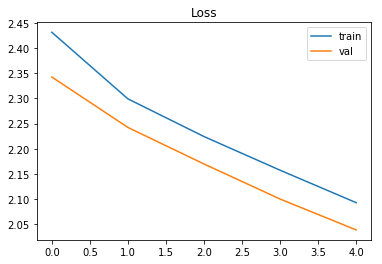

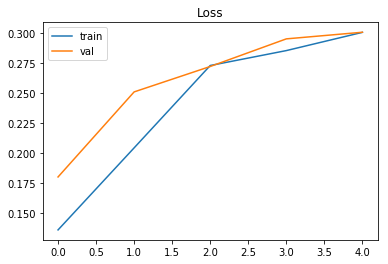

In [116]:
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
#for param in model_conv.parameters():
#    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
#optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 2.3614 Acc: 0.1417
val Loss: 2.3151 Acc: 0.1638

Epoch 1/24
----------
train Loss: 2.3190 Acc: 0.1705
val Loss: 2.2972 Acc: 0.1748

Epoch 2/24
----------
train Loss: 2.3058 Acc: 0.1884
val Loss: 2.2835 Acc: 0.1794

Epoch 3/24
----------
train Loss: 2.2939 Acc: 0.2009
val Loss: 2.2712 Acc: 0.1822

Epoch 4/24
----------
train Loss: 2.2833 Acc: 0.2050
val Loss: 2.2602 Acc: 0.1978

Epoch 5/24
----------
train Loss: 2.2736 Acc: 0.2119
val Loss: 2.2500 Acc: 0.2006

Epoch 6/24
----------
train Loss: 2.2646 Acc: 0.2181
val Loss: 2.2407 Acc: 0.2107

Epoch 7/24
----------
train Loss: 2.2571 Acc: 0.2193
val Loss: 2.2378 Acc: 0.2355

Epoch 8/24
----------
train Loss: 2.2550 Acc: 0.2319
val Loss: 2.2367 Acc: 0.2420

Epoch 9/24
----------
train Loss: 2.2539 Acc: 0.2363
val Loss: 2.2358 Acc: 0.2447

Epoch 10/24
----------
train Loss: 2.2531 Acc: 0.2372
val Loss: 2.2349 Acc: 0.2438

Epoch 11/24
----------
train Loss: 2.2522 Acc: 0.2377
val Loss: 2.2341 Acc: 0.2447

Ep

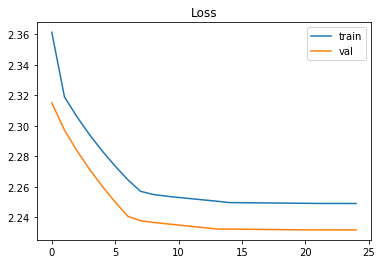

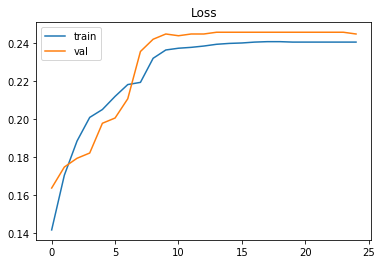

In [11]:
torch.random.manual_seed(12345)
model_conv.apply(reset)
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
model_conv_sgd_0001 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/9
----------
train Loss: 2.3429 Acc: 0.1618
val Loss: 2.2856 Acc: 0.1785

Epoch 1/9
----------
train Loss: 2.2560 Acc: 0.2080
val Loss: 2.2280 Acc: 0.1978

Epoch 2/9
----------
train Loss: 2.2093 Acc: 0.2315
val Loss: 2.1888 Acc: 0.2098

Epoch 3/9
----------
train Loss: 2.1757 Acc: 0.2494
val Loss: 2.1593 Acc: 0.2291

Epoch 4/9
----------
train Loss: 2.1487 Acc: 0.2648
val Loss: 2.1355 Acc: 0.2392

Epoch 5/9
----------
train Loss: 2.1259 Acc: 0.2782
val Loss: 2.1153 Acc: 0.2475

Epoch 6/9
----------
train Loss: 2.1059 Acc: 0.2883
val Loss: 2.0978 Acc: 0.2530

Epoch 7/9
----------
train Loss: 2.0882 Acc: 0.2950
val Loss: 2.0825 Acc: 0.2649

Epoch 8/9
----------
train Loss: 2.0721 Acc: 0.3030
val Loss: 2.0688 Acc: 0.2732

Epoch 9/9
----------
train Loss: 2.0575 Acc: 0.3102
val Loss: 2.0566 Acc: 0.2833

Training complete in 3m 56s
Best val Acc: 0.283349, epoch 9


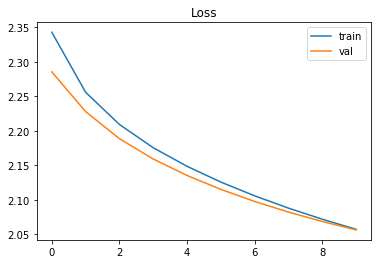

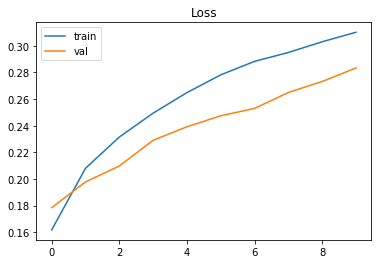

In [12]:
torch.random.manual_seed(12345)
model_conv.apply(reset)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
model_conv_sgd_001 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
train Loss: 2.2103 Acc: 0.2352
val Loss: 1.9823 Acc: 0.3358

Epoch 1/4
----------
train Loss: 1.8433 Acc: 0.4068
val Loss: 1.8657 Acc: 0.4085

Epoch 2/4
----------
train Loss: 1.6470 Acc: 0.4692
val Loss: 1.9907 Acc: 0.4048

Epoch 3/4
----------
train Loss: 1.5165 Acc: 0.5048
val Loss: 1.4425 Acc: 0.5391

Epoch 4/4
----------
train Loss: 1.4151 Acc: 0.5389
val Loss: 1.3922 Acc: 0.5566

Training complete in 1m 58s
Best val Acc: 0.556578, epoch 4


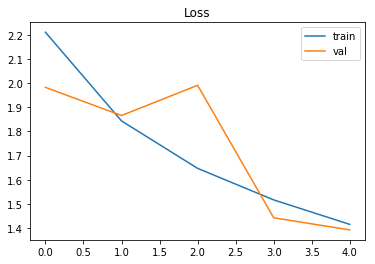

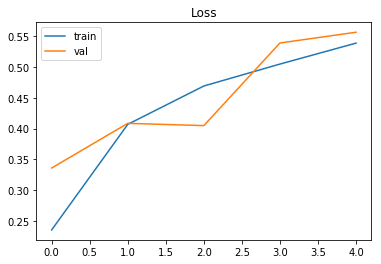

In [14]:
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)